# Finding Features for the Feedback predictor to use for prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Retrieving data from the MovieLens csv files
ratings = pd.read_csv("movielens_dataset/ratings.csv")
movies = pd.read_csv("movielens_dataset/movies.csv")
tags = pd.read_csv("movielens_dataset/tags.csv")

# Merge movies and ratings dataframes
ratings = ratings.merge(movies, on='movieId')

In [2]:
from sklearn.metrics.pairwise import cosine_similarity

# User-item matrix creation
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

user_similarity_matrix = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity_matrix, index=user_movie_matrix.index, columns=user_movie_matrix.index)

# Get top N similar users for a given user
def get_top_similar_users(similarity_df, user_id, top_n):
    user_similarities = similarity_df.loc[user_id]
    top_users = user_similarities.sort_values(ascending=False).head(top_n).index
    return top_users

ratings['top_similar_users'] = ratings['userId'].apply(lambda x: get_top_similar_users(user_similarity_df, x, 5))

In [3]:
item_similarity_matrix = cosine_similarity(user_movie_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity_matrix, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)

# Get top N similar movies for a given movie
def get_top_similar_movies(similarity_df, movie_id, top_n):
    movie_similarities = similarity_df.loc[movie_id]
    top_movies = movie_similarities.sort_values(ascending=False).head(top_n).index
    return top_movies

ratings['top_similar_movies'] = ratings['movieId'].apply(lambda x: get_top_similar_movies(item_similarity_df, x, 5))

In [4]:
print(ratings['top_similar_users'])

0         Index([1, 266, 313, 368, 57], dtype='int64', n...
1         Index([5, 470, 229, 565, 235], dtype='int64', ...
2         Index([7, 239, 399, 220, 354], dtype='int64', ...
3         Index([15, 247, 279, 434, 141], dtype='int64',...
4         Index([17, 16, 400, 434, 247], dtype='int64', ...
                                ...                        
100831    Index([610, 249, 298, 274, 380], dtype='int64'...
100832    Index([610, 249, 298, 274, 380], dtype='int64'...
100833    Index([610, 249, 298, 274, 380], dtype='int64'...
100834    Index([610, 249, 298, 274, 380], dtype='int64'...
100835    Index([610, 249, 298, 274, 380], dtype='int64'...
Name: top_similar_users, Length: 100836, dtype: object


In [5]:
genres_df = ratings['genres'].str.split('|', expand=True)

merged_df = pd.concat([ratings, genres_df], axis=1)
genres_long = pd.melt(merged_df, id_vars=['userId', 'movieId', 'title','rating', 'timestamp', 'genres'], value_vars=list(genres_df.columns))
genres_long.dropna(inplace=True)

print(merged_df)

        userId  movieId  rating   timestamp                             title  \
0            1        1     4.0   964982703                  Toy Story (1995)   
1            5        1     4.0   847434962                  Toy Story (1995)   
2            7        1     4.5  1106635946                  Toy Story (1995)   
3           15        1     2.5  1510577970                  Toy Story (1995)   
4           17        1     4.5  1305696483                  Toy Story (1995)   
...        ...      ...     ...         ...                               ...   
100831     610   160341     2.5  1479545749                  Bloodmoon (1997)   
100832     610   160527     4.5  1479544998  Sympathy for the Underdog (1971)   
100833     610   160836     3.0  1493844794                     Hazard (2005)   
100834     610   163937     3.5  1493848789                Blair Witch (2016)   
100835     610   163981     3.5  1493850155                         31 (2016)   

                           

In [6]:
# Calculate the average rating for each genre
average_rating_per_genre = genres_long.groupby('value')['rating'].mean()

# weighted_avg_rating column contains the average rating for each movie based on the average ratings of its constituent genres
merged_df['weighted_avg_rating'] = merged_df.apply(lambda row: sum(average_rating_per_genre[genre] for genre in row[8:].dropna()) / len(row[6:].dropna()), axis=1)

# Add number of genres feature
merged_df['num_genres'] = merged_df['genres'].str.count('\|') + 1

# average rating
user_average_ratings = ratings.groupby('userId')['rating'].mean()
user_average_ratings_df = user_average_ratings.reset_index(name='user_avg_rating')
merged_df = merged_df.merge(user_average_ratings_df, on='userId', how='left')

# check if drama is part of genres
merged_df['is_drama'] = merged_df['genres'].apply(lambda x: 'Drama' in x.split('|')).astype(int)

# use date
merged_df['datetime'] = pd.to_datetime(merged_df['timestamp'], unit='s')  # unit depends on the timestamp format
merged_df['hour'] = merged_df['datetime'].dt.hour  # Hour of the day
merged_df['day_of_week'] = merged_df['datetime'].dt.dayofweek  # Day of the week (Monday=0, Sunday=6)
merged_df['day'] = merged_df['datetime'].dt.day  # Day of the month
merged_df['month'] = merged_df['datetime'].dt.month  # Month
merged_df['year'] = merged_df['datetime'].dt.year  # Year

# count of users rating
user_rating_count = ratings.groupby('userId')['rating'].count().rename('user_rating_count')
merged_df = merged_df.merge(user_rating_count, how='left', on='userId')

# liked genres
movies_genres = movies['genres'].str.get_dummies(sep='|')
ratings_genres = ratings.merge(movies_genres, left_on='movieId', right_index=True, how='left')
user_genre_ratings = ratings_genres.iloc[:, -movies_genres.shape[1]:].multiply(ratings_genres['rating'], axis='index')
user_genre_ratings['userId'] = ratings_genres['userId']
user_genre_preferences = user_genre_ratings.groupby('userId').mean()
overall_avg_rating = ratings['rating'].mean()
user_liked_genres = user_genre_preferences.gt(overall_avg_rating).astype(int)
merged_df = merged_df.merge(user_liked_genres, on='userId', how='left')

# movie ratings average
movie_average_ratings = merged_df.groupby('movieId')['rating'].mean().reset_index(name='movie_avg_rating')
merged_df = merged_df.merge(movie_average_ratings, on='movieId', how='left')

# movie popularity
movie_popularity = merged_df.groupby('movieId')['rating'].count().reset_index(name='movie_rating_count')
merged_df = merged_df.merge(movie_popularity, on='movieId', how='left')
movie_popularity = ratings.groupby('movieId')['rating'].count().reset_index(name='movie_rating_count')
popularity_threshold = movie_popularity['movie_rating_count'].median()
movie_popularity['is_popular'] = (movie_popularity['movie_rating_count'] >= popularity_threshold).astype(int)
merged_df = merged_df.merge(movie_popularity[['movieId', 'is_popular']], on='movieId', how='left')

# Aggregate the tags for each movie by user
aggregated_tags = tags.groupby(['userId', 'movieId'])['tag'].apply(list).reset_index(name='aggregated_tags')

print(aggregated_tags)

# Merge the aggregated tags with the ratings dataframe
merged_df = merged_df.merge(aggregated_tags, on=['movieId', 'userId'], how='left')
merged_df['aggregated_tags'] = merged_df['aggregated_tags'].apply(lambda x: x if isinstance(x, list) else [])
merged_df['tag_count'] = merged_df['aggregated_tags'].apply(len)

print(merged_df)


      userId  movieId                              aggregated_tags
0          2    60756       [funny, Highly quotable, will ferrell]
1          2    89774               [Boxing story, MMA, Tom Hardy]
2          2   106782  [drugs, Leonardo DiCaprio, Martin Scorsese]
3          7    48516                               [way too long]
4         18      431                 [Al Pacino, gangster, mafia]
...      ...      ...                                          ...
1770     606     6107                               [World War II]
1771     606     7382                                  [for katie]
1772     606     7936                                    [austere]
1773     610     3265                   [gun fu, heroic bloodshed]
1774     610   168248                           [Heroic Bloodshed]

[1775 rows x 3 columns]
        userId  movieId  rating   timestamp                             title  \
0            1        1     4.0   964982703                  Toy Story (1995)   
1        

In [7]:
column_names = merged_df.columns
print(column_names)

Index([             'userId',             'movieId',              'rating',
                 'timestamp',               'title',              'genres',
         'top_similar_users',  'top_similar_movies',                     0,
                           1,                     2,                     3,
                           4,                     5,                     6,
                           7,                     8,                     9,
       'weighted_avg_rating',          'num_genres',     'user_avg_rating',
                  'is_drama',            'datetime',                'hour',
               'day_of_week',                 'day',               'month',
                      'year',   'user_rating_count',  '(no genres listed)',
                    'Action',           'Adventure',           'Animation',
                  'Children',              'Comedy',               'Crime',
               'Documentary',               'Drama',             'Fantasy',
            

In [8]:
ratings = merged_df.drop(['title', 'genres', 0, 1, 2, 3, 4, 5, 7, 8, 9,6, 'datetime', 'aggregated_tags','(no genres listed)',
                    'Action',           'Adventure',           'Animation',
                  'Children',              'Comedy',               'Crime',
               'Documentary',               'Drama',             'Fantasy',
                 'Film-Noir',              'Horror',                'IMAX',
                   'Musical',             'Mystery',             'Romance',
                    'Sci-Fi',            'Thriller',                 'War',
                   'Western' ], axis=1)

In [9]:
user_means = user_movie_matrix.mean(axis=1)

# Calculate the average of user means
def average_user_means(users):
    return user_means.loc[users].mean()

ratings['avg_rating_similar_users'] = ratings['top_similar_users'].apply(average_user_means)

# Calculate the average rating if there are ratings
def calculate_average_rating(similar_movies_ids, all_ratings_df):
    similar_movies_ratings = all_ratings_df[all_ratings_df['movieId'].isin(similar_movies_ids)]
    
    if not similar_movies_ratings.empty:
        return similar_movies_ratings['rating'].mean()
    else:
        return np.nan


ratings['avg_rating_of_similar_movies'] = ratings['top_similar_movies'].apply(
    lambda x: calculate_average_rating(x, ratings)
)

overall_avg_rating = ratings['rating'].mean()
ratings['avg_rating_of_similar_movies'].fillna(overall_avg_rating, inplace=True)


In [10]:
from scipy.sparse import csr_matrix
import numpy as np

sparse_matrix = csr_matrix(user_movie_matrix.fillna(0))  

# Function to compute mean ratings for movies in 'top_similar_movies'
def compute_means(movies_indices):
    filtered_matrix = sparse_matrix[:, movies_indices]
    return np.ravel(filtered_matrix.mean(axis=1))

movie_id_to_index = {movie: i for i, movie in enumerate(user_movie_matrix.columns)}
ratings['top_similar_movies_indices'] = ratings['top_similar_movies'].apply(
    lambda movies: [movie_id_to_index[movie] for movie in movies]
)

# Process in batches
batch_size = 1000 
n_samples = len(ratings)
means = []

for start in range(0, n_samples, batch_size):
    end = start + batch_size
    batch_indices = ratings['top_similar_movies_indices'][start:end]
    batch_means = np.array([compute_means(indices) for indices in batch_indices])
    means.extend(batch_means)

ratings['avg_rating_similar_movies'] = means

In [11]:
print(ratings)

        userId  movieId  rating   timestamp  \
0            1        1     4.0   964982703   
1            5        1     4.0   847434962   
2            7        1     4.5  1106635946   
3           15        1     2.5  1510577970   
4           17        1     4.5  1305696483   
...        ...      ...     ...         ...   
100831     610   160341     2.5  1479545749   
100832     610   160527     4.5  1479544998   
100833     610   160836     3.0  1493844794   
100834     610   163937     3.5  1493848789   
100835     610   163981     3.5  1493850155   

                                        top_similar_users  \
0       Index([1, 266, 313, 368, 57], dtype='int64', n...   
1       Index([5, 470, 229, 565, 235], dtype='int64', ...   
2       Index([7, 239, 399, 220, 354], dtype='int64', ...   
3       Index([15, 247, 279, 434, 141], dtype='int64',...   
4       Index([17, 16, 400, 434, 247], dtype='int64', ...   
...                                                   ...   
100831  

In [12]:
ratings = ratings.drop(['avg_rating_similar_movies', 'top_similar_users', 'avg_rating_similar_movies', 'top_similar_movies'], axis=1)
print(ratings)

        userId  movieId  rating   timestamp  weighted_avg_rating  num_genres  \
0            1        1     4.0   964982703             2.489603           5   
1            5        1     4.0   847434962             2.489603           5   
2            7        1     4.5  1106635946             2.489603           5   
3           15        1     2.5  1510577970             2.489603           5   
4           17        1     4.5  1305696483             2.489603           5   
...        ...      ...     ...         ...                  ...         ...   
100831     610   160341     2.5  1479545749             1.735422           2   
100832     610   160527     4.5  1479544998             2.152493           3   
100833     610   160836     3.0  1493844794             2.119575           3   
100834     610   163937     3.5  1493848789             1.687975           2   
100835     610   163981     3.5  1493850155             1.086065           1   

        user_avg_rating  is_drama  hour

In [13]:
ratings = ratings.drop(['top_similar_movies_indices'], axis=1)

In [14]:
column_names = ratings.columns
print(column_names)

Index(['userId', 'movieId', 'rating', 'timestamp', 'weighted_avg_rating',
       'num_genres', 'user_avg_rating', 'is_drama', 'hour', 'day_of_week',
       'day', 'month', 'year', 'user_rating_count', 'movie_avg_rating',
       'movie_rating_count', 'is_popular', 'tag_count',
       'avg_rating_similar_users', 'avg_rating_of_similar_movies'],
      dtype='object')


### Importance of the found features in the graph

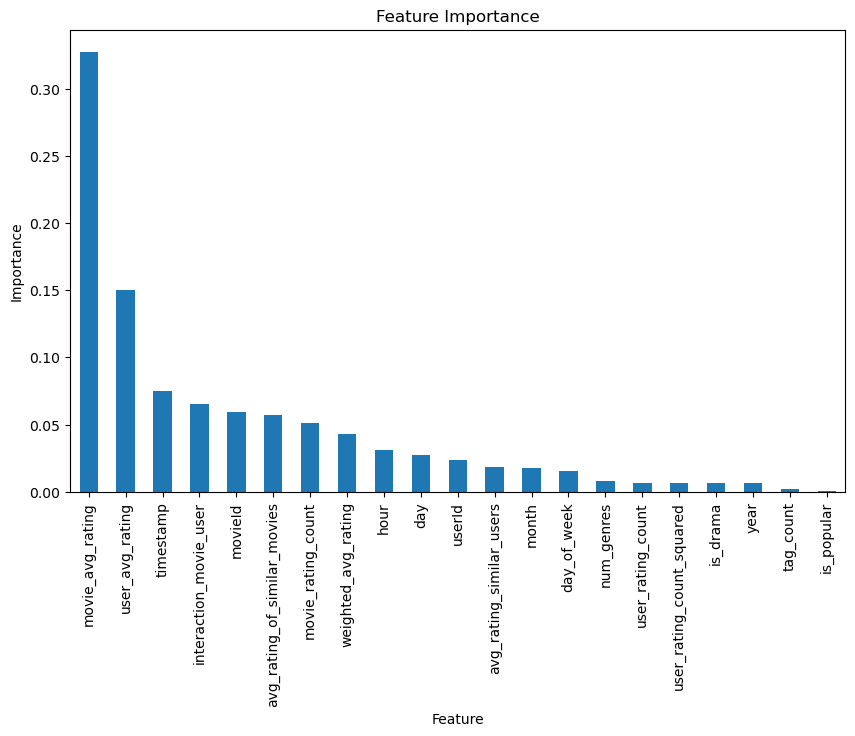

In [92]:
import matplotlib.pyplot as plt

import pandas as pd

model.fit(X, y)

feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
feature_importances['importance'].plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


# Creation of Feedback Predictor

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures

X = ratings.drop('rating', axis=1)
y = ratings['rating']

X['interaction_movie_user'] = X['movie_avg_rating'] * X['user_rating_count']
X['user_rating_count_squared'] = X['user_rating_count'] ** 2

column_names = X.columns
print(column_names)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# A pipeline is created first, then fits an XGBoost model
pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# hyperparameters for grid search
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 6],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__gamma': [0, 0.1, 0.2],
    'xgb__subsample': [0.8, 1]
}

# Initialize and run grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5), scoring='neg_mean_squared_error', verbose=3)
grid_search.fit(X_train, y_train)

if grid_search.best_estimator_:
    best_model = grid_search.best_estimator_

    # Predict and evaluate the model
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**0.5
    print(f"Root Mean Squared Error: {rmse}")

else:
    print("Grid search did not result in a valid model.")


Index(['userId', 'movieId', 'timestamp', 'weighted_avg_rating', 'num_genres',
       'user_avg_rating', 'is_drama', 'hour', 'day_of_week', 'day', 'month',
       'year', 'user_rating_count', 'movie_avg_rating', 'movie_rating_count',
       'is_popular', 'tag_count', 'avg_rating_similar_users',
       'avg_rating_of_similar_movies', 'interaction_movie_user',
       'user_rating_count_squared'],
      dtype='object')
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8;, score=-0.747 total time=   0.2s
[CV 2/5] END xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8;, score=-0.745 total time=   0.2s
[CV 3/5] END xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8;, score=-0.738 total time=   0.2s
[CV 4/5] END xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_esti

### Saving the model into a file for future use

In [17]:
from joblib import dump, load

# Save the model to a file
dump(best_model, 'best_model.joblib')

['best_model.joblib']

# Evaluation

## Random Feedback Generator (Baseline System)

In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report

# Generate random baseline predictions
def random_baseline(y_true, seed=None):
    np.random.seed(seed)
    random_predictions = np.random.randint(1, 6, size=len(y_true))
    return random_predictions
random_preds = random_baseline(y_test, seed=42)

# Compute RMSE
mse = mean_squared_error(y_test, random_preds)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# convert ratings to categories
def convert_to_categories(ratings):
    categories = []
    for rating in ratings:
        if rating <= 2:
            categories.append('dislike')
        elif rating <= 4:
            categories.append('like')
        else:
            categories.append('perfect')
    return categories

# Convert both actual and predicted ratings to categorical
true_categories = convert_to_categories(y_test)
predicted_categories = convert_to_categories(random_preds)

# Calculate accuracy
accuracy = accuracy_score(true_categories, predicted_categories)
print(f"Accuracy: {accuracy}")

# Evaluation
conf_matrix = confusion_matrix(true_categories, predicted_categories, labels=['dislike', 'like', 'perfect'])
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(true_categories, predicted_categories))


Root Mean Squared Error: 1.8291254600029807
Accuracy: 0.35431790233646715
Confusion Matrix:
[[1371 1304  675]
 [6589 6486 3331]
 [2192 2186 1075]]
Classification Report:
              precision    recall  f1-score   support

     dislike       0.14      0.41      0.20      3350
        like       0.65      0.40      0.49     16406
     perfect       0.21      0.20      0.20      5453

    accuracy                           0.35     25209
   macro avg       0.33      0.33      0.30     25209
weighted avg       0.49      0.35      0.39     25209



## Simulator Feedback Generator Evaluation

In [18]:
import numpy as np

# convert ratings to categories
def convert_to_categories(predictions):
    return np.where(predictions <= 2.8, 'dislike',
                    np.where(predictions <= 3.8, 'like', 'perfect'))

# Predict using the predictor model
y_pred = best_model.predict(X_test)

# Converting numeric predictions into categories
predicted_categories = convert_to_categories(y_pred)

In [19]:
from sklearn.metrics import classification_report, accuracy_score

true_categories = convert_to_categories(y_test)

print(classification_report(true_categories, predicted_categories))
print("Accuracy:", accuracy_score(true_categories, predicted_categories))


              precision    recall  f1-score   support

     dislike       0.66      0.53      0.59      4724
        like       0.47      0.67      0.55      8351
     perfect       0.79      0.62      0.69     12134

    accuracy                           0.62     25209
   macro avg       0.64      0.61      0.61     25209
weighted avg       0.66      0.62      0.63     25209

Accuracy: 0.6181125788408901
